# Perform POD of data that is in disk

For this example we do not include the data in the repository.

So please, work with your own data and experiment!

We do show the general process to follow.

Note that you should check the input.json file to change some of the configuration.

You do not need to do that of course. You can also modify the values directly in this notebook.

In [1]:
import json
import numpy as np

# Import MPI
from mpi4py import MPI #equivalent to the use of MPI_init() in C

# Split communicator for MPI - MPMD
worldcomm = MPI.COMM_WORLD
worldrank = worldcomm.Get_rank()
worldsize = worldcomm.Get_size()
col = 1
comm = worldcomm.Split(col,worldrank)
rank = comm.Get_rank()
size = comm.Get_size()

Read the input file

In [2]:
# Open input file to see path
f = open ("inputs.json", "r") 
params_file = json.loads(f.read())
f.close()

# Read the POD inputs
pod_number_of_snapshots = params_file["number_of_snapshots"]
pod_fields = params_file["fields"]
number_of_pod_fields = len(pod_fields)
pod_batch_size = params_file["batch_size"]
pod_keep_modes = params_file["keep_modes"]
pod_write_modes = params_file["write_modes"]



Import pynektools functions

In [4]:
# Import IO helper functions
from pynektools.io.utils import get_fld_from_ndarray, IoPathData as io_path_data

# Import modules for reading and writing
from pynektools.ppymech.neksuite import preadnek, pwritenek
# Import the data types
from pynektools.datatypes.msh import MSH as msh_c
from pynektools.datatypes.coef import COEF as coef_c
from pynektools.datatypes.field import FLD as field_c
from pynektools.datatypes.utils import create_hexadata_from_msh_fld
# Import types asociated with POD
from pynektools.rom.pod import POD as POD_c
from pynektools.rom.io_help import IoHelp as io_help_c

# Read the data paths from the input file
mesh_data = io_path_data(params_file["IO"]["mesh_data"])
field_data = io_path_data(params_file["IO"]["field_data"])

# Initialize the POD objects

In [5]:
# Instance the POD object
pod = POD_c(comm, number_of_modes_to_update = pod_keep_modes, global_updates = True, auto_expand = False, threads = 1)

# Initialize the mesh file
path     = mesh_data.dataPath
casename = mesh_data.casename
index    = mesh_data.index
fname    = path+casename+'0.f'+str(index).zfill(5)
data     = preadnek(fname, comm)
msh      = msh_c(comm, data = data)
del data

# Initialize coef to get the mass matrix
coef = coef_c(msh, comm)
bm = coef.B

# Instance io helper that will serve as buffer for the snapshots
ioh = io_help_c(comm, number_of_fields = number_of_pod_fields, batch_size = pod_batch_size, field_size = bm.size)
ioh_unscaled = io_help_c(comm, number_of_fields = number_of_pod_fields, batch_size = pod_batch_size, field_size = bm.size, module_name = "io_helper_2")

# Put the mass matrix in the appropiate format (long 1d array)
mass_list = []
for i in range(0, number_of_pod_fields):
    mass_list.append(np.copy(np.sqrt(bm)))
ioh.copy_fieldlist_to_xi(mass_list)
ioh.bm1sqrt[:,:] = np.copy(ioh.xi[:,:])

# Put the mass matrix in the appropiate format (long 1d array)
mass_list = []
for i in range(0, number_of_pod_fields):
    mass_list.append(np.copy((bm)))
ioh_unscaled.copy_fieldlist_to_xi(mass_list)
ioh_unscaled.bm1[:,:] = np.copy(ioh_unscaled.xi[:,:])

2024-07-07 15:37:53,414 - pod - WARNING - ifget_all_modes is hard coded to False. This parameter applies to lcl updates. It controls if one gets all modes in the global rotation, despite keeping less modes locally. I do not see a use for this in production runs. Thus it is set to false. If needed, activate in mpi_spSVD.py module (logger.py:73)
2024-07-07 15:37:53,416 - pod - INFO - POD Object initialized (logger.py:69)
2024-07-07 15:38:17,049 - io_helper - INFO - io_helper object initialized (logger.py:69)
2024-07-07 15:38:17,051 - io_helper_2 - INFO - io_helper object initialized (logger.py:69)


# Stream data and perform SVD

In [6]:
j = 0
while j < pod_number_of_snapshots:
    
    # Recieve the data from fortran
    path     = field_data.dataPath
    casename = field_data.casename
    index    = field_data.index
    fname=path+casename+'0.f'+str(index + j).zfill(5)
    fld_data = preadnek(fname, comm)
   
    # Get the data in field format
    fld = field_c(comm, data = fld_data)

    # Get the required fields
    u = fld.fields["vel"][0]
    v = fld.fields["vel"][1]
    w = fld.fields["vel"][2]

    u_ = np.copy(u)
    v_ = np.copy(v)
    w_ = np.copy(w)

    # Put the snapshot data into a column array
    ioh.copy_fieldlist_to_xi([u, v, w])
    ioh_unscaled.copy_fieldlist_to_xi([u_, v_, w_])

    # Load the column array into the buffer
    ioh.load_buffer(scale_snapshot = True)
    ioh_unscaled.load_buffer(scale_snapshot = False)
    
    # Update POD modes
    if ioh.update_from_buffer:

        # Find the mean of the snapshots
        ## For the scaled snapshots
        scaled_mean = np.mean(ioh.buff[:,:(ioh.buffer_index)], axis = 1)
        scaled_mean = scaled_mean.reshape(-1,1)
        ## For the unscaled snapshots to be used in the ROM
        s_mean = np.mean(ioh_unscaled.buff[:,:(ioh_unscaled.buffer_index)], axis = 1)
        s_mean = s_mean.reshape(-1,1)

        # Write the means
        field_list1d = ioh.split_narray_to_1dfields(s_mean[:,0])
        u_mean = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
        v_mean = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
        w_mean = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv) 
    
        ## Create an empty field and update its metadata
        out_fld = field_c(comm)
        out_fld.fields["scal"].append(u_mean)
        out_fld.fields["scal"].append(v_mean)
        out_fld.fields["scal"].append(w_mean)
        out_fld.update_vars()
    
        ## Create the hexadata to write out
        out_data = create_hexadata_from_msh_fld(msh = msh, fld = out_fld)
    
        ## Write out a file
        fname = "mean_field0.f"+str(j).zfill(5)
        pwritenek("./"+fname,out_data, comm)
        print("Wrote file: " + fname)
        
        # Subtract the scaled mean from the scaled snapshot before the POD
        ioh.buff[:,:(ioh.buffer_index)] = ioh.buff[:,:(ioh.buffer_index)] - scaled_mean

        # Perform the POD
        pod.update(comm, buff = ioh.buff[:,:(ioh.buffer_index)])


    j += 1

2024-07-07 15:38:18,014 - io_helper - INFO - Loaded snapshot in buffer in pos: 0 (logger.py:69)
2024-07-07 15:38:18,077 - io_helper_2 - INFO - Loaded snapshot in buffer in pos: 0 (logger.py:69)
2024-07-07 15:38:18,603 - io_helper - INFO - Loaded snapshot in buffer in pos: 1 (logger.py:69)
2024-07-07 15:38:18,610 - io_helper_2 - INFO - Loaded snapshot in buffer in pos: 1 (logger.py:69)
2024-07-07 15:38:19,135 - io_helper - INFO - Loaded snapshot in buffer in pos: 2 (logger.py:69)
2024-07-07 15:38:19,142 - io_helper_2 - INFO - Loaded snapshot in buffer in pos: 2 (logger.py:69)
2024-07-07 15:38:19,666 - io_helper - INFO - Loaded snapshot in buffer in pos: 3 (logger.py:69)
2024-07-07 15:38:19,673 - io_helper_2 - INFO - Loaded snapshot in buffer in pos: 3 (logger.py:69)
2024-07-07 15:38:20,189 - io_helper - INFO - Loaded snapshot in buffer in pos: 4 (logger.py:69)
2024-07-07 15:38:20,196 - io_helper_2 - INFO - Loaded snapshot in buffer in pos: 4 (logger.py:69)
2024-07-07 15:38:20,714 - io_h

# Perform Post - stream operations

So here, we can check if the buffer still has some data that has not been taking into account in the POD.

We also scale back the modes

In [7]:

# Check if there is information in the buffer that should be taken in case the loop exit without flushing
if ioh.buffer_index > ioh.buffer_max_index:
    ioh.log.write("info","All snapshots where properly included in the updates")
else: 
    ioh.log.write("warning","Last loaded snapshot to buffer was: "+repr(ioh.buffer_index-1))
    ioh.log.write("warning","The buffer updates when it is full to position: "+repr(ioh.buffer_max_index))
    ioh.log.write("warning","Data must be updated now to not lose anything,  Performing an update with data in buffer ")
    pod.update(comm, buff = ioh.buff[:,:(ioh.buffer_index)])

# Scale back the modes
pod.scale_modes(comm, bm1sqrt = ioh.bm1sqrt, op = "div")

# Rotate local modes back to global, This only enters in effect if global_update = false
pod.rotate_local_modes_to_global(comm)

2024-07-07 15:39:33,297 - io_helper - INFO - All snapshots where properly included in the updates (logger.py:69)
2024-07-07 15:39:33,299 - pod - INFO - Rescaling the obtained modes... (logger.py:69)
2024-07-07 15:39:33,400 - pod - INFO - Rescaling the obtained modes... Done (logger.py:69)


# Write data

Write fields with POD modes and npy files with the singular values and vectors

In [8]:
# Go over the modes
for j in range(0, pod_write_modes):
    
    ## Split the snapshots into the proper fields
    field_list1d = ioh.split_narray_to_1dfields(pod.u_1t[:,j])
    u_mode = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
    v_mode = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
    w_mode = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv) 
    
    ## Create an empty field and update its metadata
    out_fld = field_c(comm)
    out_fld.fields["scal"].append(u_mode)
    out_fld.fields["scal"].append(v_mode)
    out_fld.fields["scal"].append(w_mode)
    out_fld.update_vars()
    
    ## Create the hexadata to write out
    out_data = create_hexadata_from_msh_fld(msh = msh, fld = out_fld)
    
    ## Write out a file
    fname = "modes0.f"+str(j).zfill(5)
    pwritenek("./"+fname,out_data, comm)
    print("Wrote file: " + fname)


if comm.Get_rank() == 0:
    np.save("singular_values", pod.d_1t)
    print("Wrote signular values")
    np.save("right_singular_vectors", pod.vt_1t)
    print("Wrote right signular values")

Wrote file: modes0.f00000
Wrote file: modes0.f00001
Wrote file: modes0.f00002
Wrote file: modes0.f00003
Wrote file: modes0.f00004
Wrote file: modes0.f00005
Wrote file: modes0.f00006
Wrote file: modes0.f00007
Wrote file: modes0.f00008
Wrote file: modes0.f00009
Wrote signular values
Wrote right signular values


# Visualize some of the data

## Modes

For this case, visualizing the modes might require paraview or visit. So please go ahead and try

## Singular values:

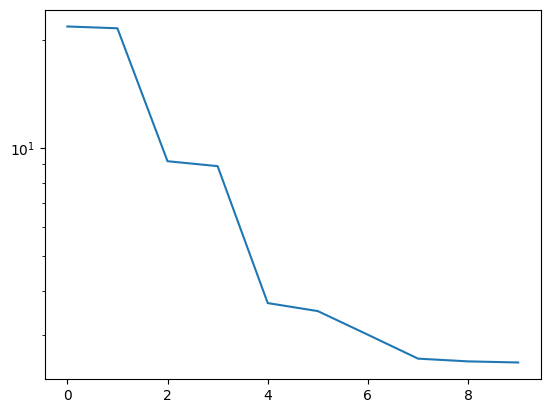

In [9]:
import matplotlib.pyplot as plt

d = np.load("singular_values.npy")

plt.semilogy(d)
plt.show()

Note how mode 0 has the larger energy, and represents the mean. Afterwards, modes come in pairs of energy, representing traveling waves.

## Time coefficients

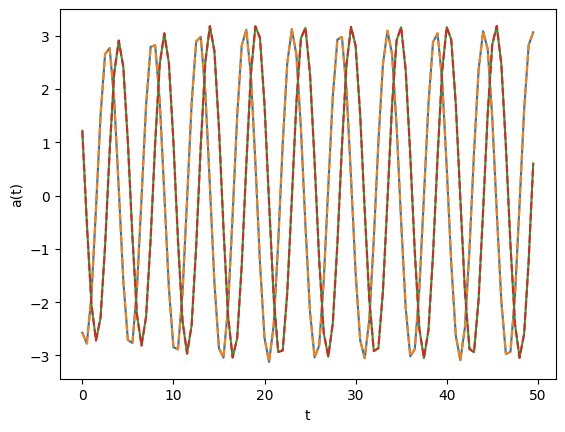

In [10]:
# Time coefficients read from the POD
vt = np.load("right_singular_vectors.npy")
T = np.diag(d)@vt

# Time coefficients projecting the snapshots into a number of modes
M = 7
snaps = T.shape[1]
aa = np.zeros((M, snaps))
time = np.arange(len(aa[0,:]))*0.5    

for i in range(0,snaps):
    centered_snapshot = (ioh_unscaled.buff[:,i]-s_mean[:,0]).reshape(-1,1)
    projection = pod.u_1t[:, :M].T@(ioh_unscaled.bm1*centered_snapshot)
    aa[:,i] = np.copy(projection[:,0]) # Here, the inner product is with respect to the weights

plt.plot(time, T[0,:])
plt.plot(time, aa[0,:], "--")
plt.xlabel("t")
plt.ylabel("a(t)")

plt.plot(time, T[1,:])
plt.plot(time, aa[1,:], "--")
plt.xlabel("t")
plt.ylabel("a(t)")
plt.show()



See here how the mode 0 represents the mean flow. And how the paired modes are shifted by a phase of 90 degrees and serve to represent the travelling nature of the wave

# Galerkin projection based on iliescu

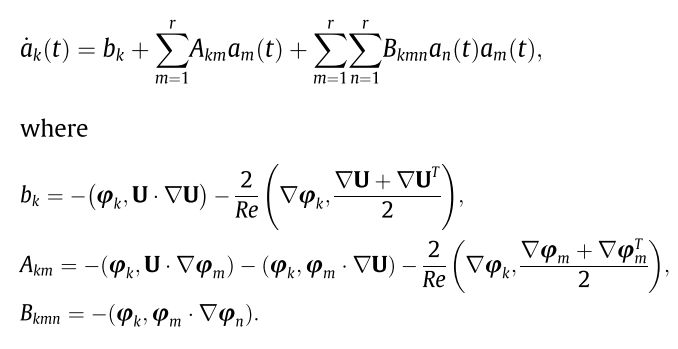

In [11]:
def get_gradU(u, v, w, msh, coef):

    grad = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3, 3)) # For each point, I get a tensor

    # Fill the Gradient 
    grad[:,:,:,:,0,0] = coef.dudxyz(u, coef.drdx, coef.dsdx, coef.dtdx) #dudx
    grad[:,:,:,:,0,1] = coef.dudxyz(u, coef.drdy, coef.dsdy, coef.dtdy) #dudy
    grad[:,:,:,:,0,2] = coef.dudxyz(u, coef.drdz, coef.dsdz, coef.dtdz) #dudz
    
    grad[:,:,:,:,1,0] = coef.dudxyz(v, coef.drdx, coef.dsdx, coef.dtdx) #dudx
    grad[:,:,:,:,1,1] = coef.dudxyz(v, coef.drdy, coef.dsdy, coef.dtdy) #dudy
    grad[:,:,:,:,1,2] = coef.dudxyz(v, coef.drdz, coef.dsdz, coef.dtdz) #dudz
    
    grad[:,:,:,:,2,0] = coef.dudxyz(w, coef.drdx, coef.dsdx, coef.dtdx) #dudx
    grad[:,:,:,:,2,1] = coef.dudxyz(w, coef.drdy, coef.dsdy, coef.dtdy) #dudy
    grad[:,:,:,:,2,2] = coef.dudxyz(w, coef.drdz, coef.dsdz, coef.dtdz) #dudz

    return grad

def get_gradU_p_gradUT(grad_U, msh):

    grad_U_UT   = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3, 3)) 
    
    for e in range(0, msh.nelv):
        for k in range(0, msh.lz):
            for j in range(0, msh.ly):
                for i in range(0, msh.lx):
                    grad_U_UT[e, k, j, i, :, :] = grad_U[e, k, j, i, :, :] + grad_U[e, k, j, i, :, :].T 

    return grad_U_UT

def get_UgradU(U, grad_U, msh):

    U_grad_U   = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3)) # For each point, 3 arrays, one for each velocity
    
    for e in range(0, msh.nelv):
        for k in range(0, msh.lz):
            for j in range(0, msh.ly):
                for i in range(0, msh.lx):
                    U_grad_U[e, k, j, i, :] = (grad_U[e, k, j, i, :, :] @ np.array([U[e, k, j, i, 0], U[e, k, j, i, 1], U[e, k, j, i, 2]]).reshape(-1,1))[:,0] 

    return U_grad_U

In [14]:
b = np.zeros((M))
A = np.zeros((M, M))
B = np.zeros((M, M, M))

re = 160

# Allocate arrays
phi_k      = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3)) # For each point, 3 arrays, one for each velocity
phi_m      = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3)) # For each point, 3 arrays, one for each velocity
phi_n      = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3)) # For each point, 3 arrays, one for each velocity
U          = np.zeros((msh.nelv, msh.lz, msh.ly, msh.lx, 3)) # For each point, 3 arrays, one for each velocity

# Put data in appropiate format
field_list1d = ioh.split_narray_to_1dfields(s_mean[:,0])
U[:,:,:,:,0] = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
U[:,:,:,:,1] = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
U[:,:,:,:,2] = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv)

bm_for_array = bm.reshape(msh.nelv, msh.lz, msh.ly, msh.lx, 1) # Just reshape in a way that we can broadcast a multiplication operation
bm_for_grad = bm.reshape(msh.nelv, msh.lz, msh.ly, msh.lx, 1, 1) # Just reshape in a way that we can broadcast a multiplication operation

# Get the gradient
grad_U = get_gradU(U[:,:,:,:,0], U[:,:,:,:,1], U[:,:,:,:,2], msh, coef)

# Get the strain matrix
grad_U_UT = get_gradU_p_gradUT(grad_U, msh)

# Get U_grad_U, i.e., non linear term
U_grad_U = get_UgradU(U, grad_U, msh)

from tqdm import tqdm

pbar= tqdm(total=M*M*M)

for k in range(0, M):

    #print("k = {}".format(k))
    
    # Get phi_k
    field_list1d = ioh.split_narray_to_1dfields(pod.u_1t[:,k])
    phi_k[:,:,:,:,0] = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
    phi_k[:,:,:,:,1] = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
    phi_k[:,:,:,:,2] = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv)

    # Grad of phi_k
    grad_phi_k = get_gradU(phi_k[:,:,:,:,0], phi_k[:,:,:,:,1], phi_k[:,:,:,:,2], msh, coef)

    # first inner product in b
    inner_phi_k_U_grad_U = np.sum(U_grad_U * phi_k * bm_for_array)
    
    # second inner product in b
    inner_grad_phi_k_grad_UUT_2 = np.sum(grad_phi_k * grad_U_UT/2 * bm_for_grad)

    # b
    b[k] = - inner_phi_k_U_grad_U - 2/re * inner_grad_phi_k_grad_UUT_2

    for m in range(0, M):

        #print("m = {}".format(m))

        # Get phi_m
        field_list1d = ioh.split_narray_to_1dfields(pod.u_1t[:,m])
        phi_m[:,:,:,:,0] = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
        phi_m[:,:,:,:,1] = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
        phi_m[:,:,:,:,2] = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv)

        # Grad of phi_m
        grad_phi_m = get_gradU(phi_m[:,:,:,:,0], phi_m[:,:,:,:,1], phi_m[:,:,:,:,2], msh, coef)

        # Get the strain matrix
        grad_phi_m_phi_mT = get_gradU_p_gradUT(grad_phi_m, msh)

        # Get non linear terms
        U_grad_phi_m = get_UgradU(U, grad_phi_m, msh)
        phi_m_grad_U = get_UgradU(phi_m, grad_U, msh)

        
        # first inner product in A
        inner_phi_k_u_grad_phi_m = np.sum(phi_k * U_grad_phi_m  * bm_for_array)

        # Second inner product in A
        inner_phi_k_phi_m_grad_u = np.sum(phi_k * phi_m_grad_U  * bm_for_array)

        # Third inner product in A
        inner_grad_phi_k_grad_phi_m_phi_mT_2 =  np.sum(grad_phi_k * grad_phi_m_phi_mT/2 * bm_for_grad)

        A[k, m] = - inner_phi_k_u_grad_phi_m - inner_phi_k_phi_m_grad_u - 2/re*inner_grad_phi_k_grad_phi_m_phi_mT_2


        for n in range(0, M):

            #print("n = {}".format(n))

            # Get phi_n
            field_list1d = ioh.split_narray_to_1dfields(pod.u_1t[:,n])
            phi_n[:,:,:,:,0] = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
            phi_n[:,:,:,:,1] = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
            phi_n[:,:,:,:,2] = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv)

            # Grad of phi_n
            grad_phi_n = get_gradU(phi_n[:,:,:,:,0], phi_n[:,:,:,:,1], phi_n[:,:,:,:,2], msh, coef)
        
            # Get non linear terms
            phi_m_grad_phi_n = get_UgradU(phi_m, grad_phi_n, msh)

            #first inner product in B
            inner_phi_k_phi_m_grad_phi_n = np.sum(phi_k * phi_m_grad_phi_n * bm_for_array)

            B[k,m,n] = - inner_phi_k_phi_m_grad_phi_n

            pbar.update(1)

pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [45:35<00:00,  7.98s/it]


In [19]:
np.save("b", b)
np.save("A", A)
np.save("B", B)

# Predictions

In [29]:
# Get initial conditions
a = np.copy(aa[:,0])

# Set up the solver
dt = 1e-4
nn = int(1/dt * 60)
t = -dt
L = np.zeros(M)

In [30]:
# arrays to store data
tt = []
a_store = np.zeros((M, nn+1))
a_store[:,0] = np.copy(a[:])
t=0
tt.append(t)

# Time stepper
pbar= tqdm(total=nn)
for i in range(0, nn):
    
    t +=dt    
    for k in range(0, M):
        
        L[k] = b[k]
        
        for m in range(0, M):
        
            L[k] = L[k] + A[k,m]*a[m]

        for m in range(0, M):
            for n in range(0, M):
                L[k] =  L[k] + B[k,m,n]*a[n]*a[m]


    for k in range(0, M):
        a[k] = a[k] + dt*L[k]

    pbar.update(1)
    tt.append(t)
    a_store[:,i+1] = np.copy(a[:])  
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600000/600000 [03:32<00:00, 2828.27it/s]


## Plot predicted time coefficients with the Galerkin POD projection

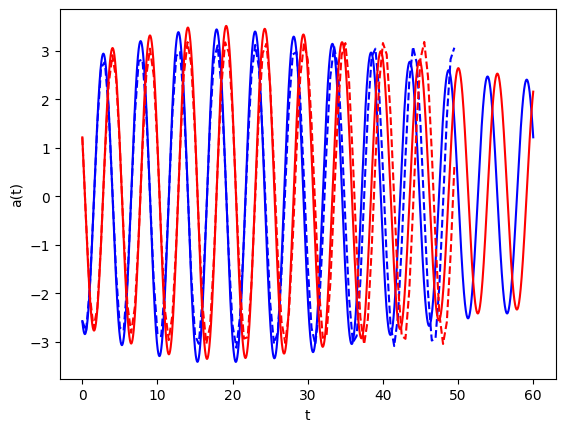

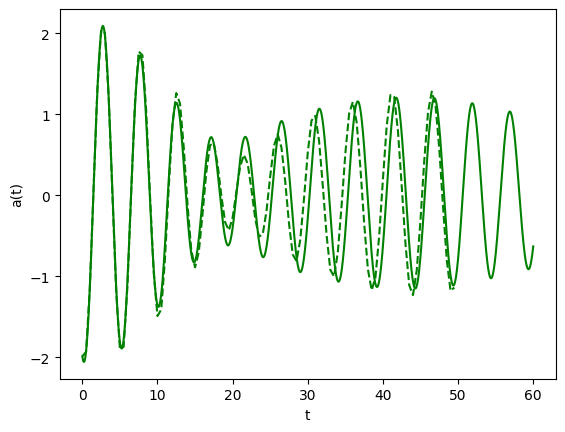

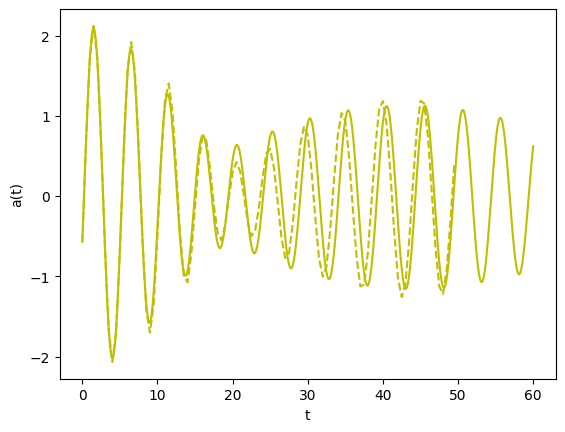

In [31]:
plt.plot(tt, a_store[0,:], "-b")
plt.plot(time, aa[0,:], "--b")
plt.plot(tt, a_store[1,:], "-r")
plt.plot(time, aa[1,:], "--r")
plt.xlabel("t")
plt.ylabel("a(t)")
plt.show()

plt.plot(tt, a_store[2,:], "-g")
plt.plot(time, aa[2,:], "--g")
plt.xlabel("t")
plt.ylabel("a(t)")
plt.show()

plt.plot(tt, a_store[3,:], "-y")
plt.plot(time, aa[3,:], "--y")
plt.xlabel("t")
plt.ylabel("a(t)")
plt.show()